In [17]:
import sys, pathlib
import pandas as pd
import matplotlib.pyplot as plt

proj_root = pathlib.Path("..").resolve()
if str(proj_root) not in sys.path:
    sys.path.insert(0, str(proj_root))

from src.dataset import build_dataset
from src.config import FEATURE_COLS, TARGET_COL
from src.evaluation import evaluate_classifier
from src.modeling import (
    build_logreg_pipeline,
    build_decision_tree,
    build_random_forest,
    build_gradient_boosting,
    grid_search_timeseries,
)


Step 2: standard ML models (from class).
We keep a time split (no shuffle) and compare models with Accuracy + ROC-AUC.

In [18]:
df_feat = build_dataset(
    include_vix=True, include_rates=True, include_usd_index=True, include_sp500=True
).sort_values("date").reset_index(drop=True)

print("Period:", df_feat["date"].min().date(), "->", df_feat["date"].max().date())
print("Shape :", df_feat.shape)
print("Target balance:", df_feat[TARGET_COL].value_counts(normalize=True).round(3))


Period: 2015-12-23 -> 2025-10-23
Shape : (2543, 38)
Target balance: y_up
1    0.504
0    0.496
Name: proportion, dtype: float64


In [19]:
TEST_START = "2018-01-01"

train_df = df_feat[df_feat["date"] < TEST_START].copy()
test_df  = df_feat[df_feat["date"] >= TEST_START].copy()

X_train = train_df[FEATURE_COLS].values
y_train = train_df[TARGET_COL].values
X_test  = test_df[FEATURE_COLS].values
y_test  = test_df[TARGET_COL].values

print("Train:", train_df["date"].min().date(), "->", train_df["date"].max().date(), "| n =", len(train_df))
print("Test :", test_df["date"].min().date(), "->", test_df["date"].max().date(), "| n =", len(test_df))


Train: 2015-12-23 -> 2017-12-29 | n = 523
Test : 2018-01-02 -> 2025-10-23 | n = 2020


In [20]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import accuracy_score, roc_auc_score

dum = DummyClassifier(strategy="most_frequent")
dum.fit(X_train, y_train)
pred = dum.predict(X_test)
print("Dummy accuracy:", round(accuracy_score(y_test, pred), 3))

dum_s = DummyClassifier(strategy="stratified", random_state=0)
dum_s.fit(X_train, y_train)
proba = dum_s.predict_proba(X_test)[:, 1]
print("Dummy ROC-AUC :", round(roc_auc_score(y_test, proba), 3))


Dummy accuracy: 0.501
Dummy ROC-AUC : 0.505


In [21]:
models = {
    "LogReg": build_logreg_pipeline(),
    "DecisionTree": build_decision_tree(),
    "RandomForest": build_random_forest(),
    "GradientBoosting": build_gradient_boosting(),
}

results = []
fitted = {}

for name, m in models.items():
    m.fit(X_train, y_train)
    acc, auc = evaluate_classifier(m, X_train, y_train, X_test, y_test, name=name)
    results.append((name, acc, auc))
    fitted[name] = m

pd.DataFrame(results, columns=["model","accuracy","roc_auc"]).sort_values("roc_auc", ascending=False)


=== LogReg ===
Accuracy: 0.497
ROC-AUC : 0.511
Confusion matrix:
 [[247 760]
 [257 756]]

Classification report:
               precision    recall  f1-score   support

           0      0.490     0.245     0.327      1007
           1      0.499     0.746     0.598      1013

    accuracy                          0.497      2020
   macro avg      0.494     0.496     0.462      2020
weighted avg      0.494     0.497     0.463      2020

=== DecisionTree ===
Accuracy: 0.501
ROC-AUC : 0.496
Confusion matrix:
 [[622 385]
 [623 390]]

Classification report:
               precision    recall  f1-score   support

           0      0.500     0.618     0.552      1007
           1      0.503     0.385     0.436      1013

    accuracy                          0.501      2020
   macro avg      0.501     0.501     0.494      2020
weighted avg      0.501     0.501     0.494      2020

=== RandomForest ===
Accuracy: 0.505
ROC-AUC : 0.506
Confusion matrix:
 [[316 691]
 [309 704]]

Classification r

,model,accuracy,roc_auc
3,GradientBoosting,0.517327,0.511434
0,LogReg,0.496535,0.511382
2,RandomForest,0.504950,0.506487
1,DecisionTree,0.500990,0.495887


In [22]:
from sklearn.ensemble import RandomForestClassifier

rf_base = RandomForestClassifier(random_state=0, n_jobs=-1)

param_grid_rf = {
    "n_estimators": [200, 400],
    "max_depth": [4, 6, 8],
    "min_samples_leaf": [20, 50],
}

rf_best, rf_params, rf_cvscore = grid_search_timeseries(
    rf_base, param_grid_rf, X_train, y_train, n_splits=5
)

print("Best RF params:", rf_params)
print("CV ROC-AUC:", round(rf_cvscore, 3))

acc_rf, auc_rf = evaluate_classifier(rf_best, X_train, y_train, X_test, y_test, name="RandomForest tuned")
results.append(("RandomForest tuned", acc_rf, auc_rf))
fitted["RandomForest tuned"] = rf_best

pd.DataFrame(results, columns=["model","accuracy","roc_auc"]).sort_values("roc_auc", ascending=False)


Best RF params: {'max_depth': 6, 'min_samples_leaf': 20, 'n_estimators': 200}
CV ROC-AUC: 0.514
=== RandomForest tuned ===
Accuracy: 0.508
ROC-AUC : 0.508
Confusion matrix:
 [[362 645]
 [348 665]]

Classification report:
               precision    recall  f1-score   support

           0      0.510     0.359     0.422      1007
           1      0.508     0.656     0.573      1013

    accuracy                          0.508      2020
   macro avg      0.509     0.508     0.497      2020
weighted avg      0.509     0.508     0.497      2020



,model,accuracy,roc_auc
3,GradientBoosting,0.517327,0.511434
0,LogReg,0.496535,0.511382
4,RandomForest tuned,0.508416,0.507599
2,RandomForest,0.504950,0.506487
1,DecisionTree,0.500990,0.495887


Best model (TEST ROC-AUC): GradientBoosting


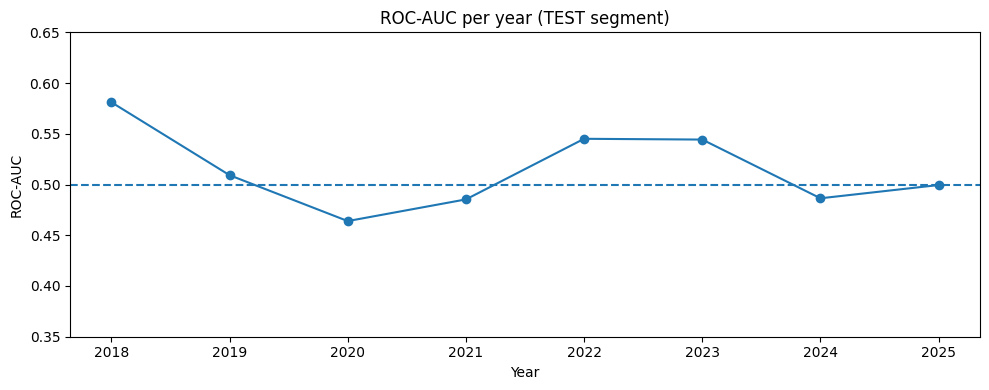

,year,roc_auc,n
0,2018,0.581096,259
1,2019,0.509199,258
2,2020,0.463982,259
3,2021,0.485342,259
4,2022,0.545072,258
5,2023,0.544312,258
6,2024,0.486440,259
7,2025,0.499500,210


In [23]:
import numpy as np
from sklearn.metrics import roc_auc_score

best_name = max(results, key=lambda x: x[2])[0]
best_model = fitted[best_name]
print("Best model (TEST ROC-AUC):", best_name)

test_df = test_df.copy()
test_df["proba_up"] = best_model.predict_proba(X_test)[:, 1]
test_df["year"] = test_df["date"].dt.year

by_year = []
for y, g in test_df.groupby("year"):
    if len(g) >= 50 and g[TARGET_COL].nunique() == 2:
        auc = roc_auc_score(g[TARGET_COL].values, g["proba_up"].values)
    else:
        auc = np.nan
    by_year.append((y, auc, len(g)))

df_auc_year = pd.DataFrame(by_year, columns=["year","roc_auc","n"]).sort_values("year")

# forcer affichage 2018->2025 même si une année manque
all_years = pd.DataFrame({"year": list(range(2018, 2026))})
df_auc_year = all_years.merge(df_auc_year, on="year", how="left")

plt.figure(figsize=(10,4))
plt.plot(df_auc_year["year"], df_auc_year["roc_auc"], marker="o")
plt.axhline(0.5, linestyle="--")
plt.title("ROC-AUC per year (TEST segment)")
plt.xlabel("Year")
plt.ylabel("ROC-AUC")
plt.ylim(0.35, 0.65)
plt.tight_layout()
plt.show()

df_auc_year
